In [1]:
import sys
sys.path.append("../")

In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from src.datasets.sst2 import load_sst2
from src.utils.logger import get_logger
from src.utils.session import reset_session

2024-12-21 12:10:24.294442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
_ = get_logger()

## Config

In [4]:
base_model_dir = "../model/"
os.makedirs(base_model_dir, exist_ok=True)

ckpt_path = os.path.join(base_model_dir, "bert_fine_tune_sst2", "ckpt")

## Load Dataset

In [5]:
(X_train_raw, y_train_raw), (X_valid_raw, y_valid_raw), (X_test_raw, y_test_raw) = load_sst2(
    num_sample=5000,
    val_split=True,
)

X_raw = {
    "X_train": X_train_raw,
    "X_valid": X_valid_raw,
    "X_test": X_test_raw,
}

y_raw = {
    "y_train": y_train_raw,
    "y_valid": y_valid_raw,
    "y_test": y_test_raw,
}

[INFO] num train: 3200 (data.py:33)
[INFO] num valid: 800 (data.py:34)
[INFO] num test: 1000 (data.py:35)


## Preproess
<!-- - we will use last hidden states to  -->

### Tokenize input sentences

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
"""
Args:
 - return_tensors: returns numpy arra
 - max_length: limit the maximum length of sentence as 30
 - padding: fill with zeros if len(sentence) < max_length
 - truncation: truncate if len(sentence) > max_length

Outputs:
 - input_ids: tokenized input ids
 - token_type_ids: 0 if first sentence, 1 if second sentence (note: BERT takes 2 sentences as input)
 - attention_mask: 0 if input_ids[i] = [PAD], 1 otherwise
"""

X_tokenized = {
    k: tokenizer(v.tolist(), return_tensors="np", max_length=30, padding="max_length", truncation=True)
    for k, v in X_raw.items()
}

In [8]:
for i in [0, 10, 13, 20]:
    tmp_raw = X_raw["X_train"][i]
    tmp_tokenized = X_tokenized["X_train"]
    tmp_ids = tmp_tokenized["input_ids"][i]
    tmp_token_type_ids = tmp_tokenized["token_type_ids"][i]
    tmp_att_msk = tmp_tokenized["attention_mask"][i]

    print("==>")
    print(f"Raw: {tmp_raw}")
    print(f"Token ids: {tmp_ids}")
    print(f"Ids to token: {' '.join(tokenizer.convert_ids_to_tokens(tmp_ids))}")
    print(f"Attention Mask: {tmp_att_msk}")
    print()

==>
Raw: a meditation on faith and madness , frailty is blood curdling stuff
Token ids: [  101  1037 13804  2006  4752  1998 12013  1010 25737  3723  2003  2668
 12731  4103  2989  4933   102     0     0     0     0     0     0     0
     0     0     0     0     0     0]
Ids to token: [CLS] a meditation on faith and madness , frail ##ty is blood cu ##rd ##ling stuff [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Attention Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

==>
Raw: has all the hallmarks of a movie designed strictly for children 's home video , a market so insatiable it absorbs all manner of lame entertainment , as long as 3 year olds find it diverting
Token ids: [  101  2038  2035  1996 25812  2015  1997  1037  3185  2881  9975  2005
  2336  1005  1055  2188  2678  1010  1037  3006  2061 16021 10450  3085
  2009 16888  2015  2035  5450   102]
Ids to token: [CLS] has all the hallmark ##s of a movie designed strictly 

### One-hot encode labels

In [9]:
y_onehot = {
    k: tf.keras.utils.to_categorical(v)
    for k, v in y_raw.items()
}

## Train model

In [10]:
reset_session()

In [11]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

2024-12-21 12:10:29.550962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-21 12:10:29.552692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-21 12:10:29.552797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-21 12:10:29.553062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [12]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = tf.keras.optimizers.Adam(2e-5)

# note that TFBertForSequenceClassification returns logits (not softmax)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [15]:
X_train = dict(X_tokenized["X_train"])
y_train = y_onehot["y_train"]

X_valid = dict(X_tokenized["X_valid"])
y_valid = y_onehot["y_valid"]

X_test = dict(X_tokenized["X_test"])
y_test = y_onehot["y_test"]

print(f"X_train: {X_train['input_ids'].shape}")
print(f"y_train: {y_train.shape}")

print(f"X_train: {X_valid['input_ids'].shape}")
print(f"y_valid: {y_valid.shape}")

print(f"X_train: {X_test['input_ids'].shape}")
print(f"y_test: {y_test.shape}")

X_train: (3200, 30)
y_train: (3200, 2)
X_train: (800, 30)
y_valid: (800, 2)
X_train: (1000, 30)
y_test: (1000, 2)


In [16]:
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    mode="min", 
    save_best_only=True,
    save_weights_only=True
)
es_cb = tf.keras.callbacks.EarlyStopping(patience=5, mode="min", verbose=1)
callbacks = [ckpt_cb, es_cb]

In [17]:
history = model.fit(
    x=dict(X_train),
    y=y_train,
    validation_data=(dict(X_valid), y_valid),
    batch_size=128,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


2024-12-21 12:10:44.983502: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1ea4d3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-21 12:10:44.983541: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-12-21 12:10:44.986556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-21 12:10:45.081253: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 40s 620ms/step - loss: 0.5893 - accuracy: 0.6978 - val_loss: 0.4322 - val_accuracy: 0.8475
Epoch 2/10
25/25 [==============================] - 16s 646ms/step - loss: 0.3629 - accuracy: 0.8753 - val_loss: 0.3384 - val_accuracy: 0.8675
Epoch 3/10
25/25 [==============================] - 16s 645ms/step - loss: 0.2445 - accuracy: 0.9234 - val_loss: 0.3093 - val_accuracy: 0.8888
Epoch 4/10
25/25 [==============================] - 12s 477ms/step - loss: 0.1707 - accuracy: 0.9488 - val_loss: 0.3232 - val_accuracy: 0.8800
Epoch 5/10
25/25 [==============================] - 12s 477ms/step - loss: 0.1173 - accuracy: 0.9709 - val_loss: 0.3465 - val_accuracy: 0.8850
Epoch 6/10
25/25 [==============================] - 12s 479ms/step - loss: 0.0969 - accuracy: 0.9756 - val_loss: 0.3418 - val_accuracy: 0.8863
Epoch 7/10
25/25 [==============================] - 12s 481ms/step - loss: 0.0815 - accuracy: 0.9800 - val_loss: 0.3785 - val_accuracy: 0.8838
Epoch 8/10

## Results

### Train History

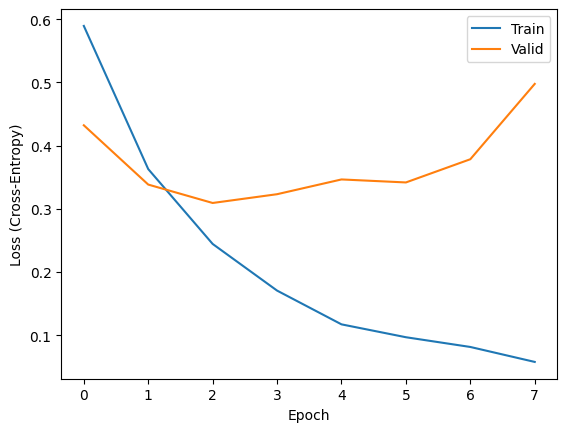

In [18]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]
xticks = range(len(train_loss))

fig, ax = plt.subplots(1, 1)
ax.plot(xticks, train_loss, label="Train")
ax.plot(xticks, valid_loss, label="Valid")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (Cross-Entropy)")
ax.set_xticks(xticks)
ax.legend()

### Classification Results

In [19]:
pred_logits_train = model.predict(X_train, batch_size=128)
pred_logits_test = model.predict(X_test, batch_size=128)

pred_probs_train = tf.nn.softmax(pred_logits_train.logits, axis=-1)
pred_probs_test = tf.nn.softmax(pred_logits_test.logits, axis=-1)

pred_train = tf.argmax(pred_probs_train, axis=-1).numpy()
pred_test = tf.argmax(pred_probs_test, axis=-1).numpy()

8/8 [==============================] - 3s 174ms/step


In [20]:
pred_train = tf.argmax(pred_probs_train, axis=-1).numpy()
pred_test = tf.argmax(pred_probs_test, axis=-1).numpy()

In [21]:
# note that classification_report takes class labels as the input (not one-hot encoded)

print(classification_report(y_train_raw, pred_train))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1544
           1       0.98      0.99      0.99      1656

    accuracy                           0.98      3200
   macro avg       0.99      0.98      0.98      3200
weighted avg       0.98      0.98      0.98      3200



In [22]:
# note that classification_report takes class labels as the input (not one-hot encoded)

print(classification_report(y_test_raw, pred_test))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       469
           1       0.82      0.95      0.88       531

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000

